<h2>Importing  Libraries</h2>


In [2]:
import pandas as pd
import numpy as np
import time
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
from PIL import *
import random
import math


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


<h2>Reading Data</h2> 

In [0]:
from google.colab import files


In [4]:
upload = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [5]:
movie_reviews = pd.read_csv('IMDB Dataset.csv', encoding = "ISO-8859-1", error_bad_lines=False, engine='python')
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
movie_reviews.duplicated().sum()

418

In [8]:
movie_reviews.drop_duplicates(keep='first').shape

(49582, 2)

In [9]:
movie_reviews.isnull().values.any()

False

In [10]:
movie_reviews.sentiment.unique()


array(['positive', 'negative'], dtype=object)

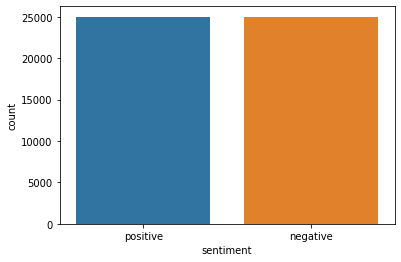

In [11]:
sns.countplot(x='sentiment', data=movie_reviews)

<h2>Data Preprocessing</h2>

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lowercase
    sentence = sentence.lower() 
    
    # Removing StopWords
    sentence = ' '.join(word for word in sentence.split() if word not in STOPWORDS)
    
    # Stemming
    tokens = sentence .split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    sentence = ' '.join(tokens)
    
    return sentence


In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))


In [18]:
print(X[1])

wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwell mural decorating every surface terribly well done


In [0]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

<h2> BERT dependencies</h2>

In [26]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=8e73238d081335c3aad2bb6753165ef5ece8c85c374fe2d8fe36ac069d13adb9
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.9.3-cp36-none-any.whl size=5995 sha256=63a18e996c1f39c5ae81406d558d963f5c0926d5ff0db9e76694596e0df1df2a
  Stored in directory: /root/.cache/pip/wheels/17/3b/1a/c1c0c9d3de79c42c7197876e2f06dcd2577dfee65c0df19b69
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=858c229c48a3d76dfcf80a100bb0ec38f6d68b169755f3388abb7db9e2c1adb0
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow


In [27]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 2.7MB/s 


In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

<h2>BERT Tokenizer</h2>


In [0]:
#In order to use BERT text embeddings as input to train text classification model


In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [0]:
tokenized_reviews = [tokenize_reviews(review) for review in X]

<h2>Prerparing Data For Training</h2>

To train the model, the input sentences should be of equal length !

In [0]:
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [0]:
random.shuffle(reviews_with_len)

In [0]:
reviews_with_len.sort(key=lambda x: x[2])

In [0]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]


In [0]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [0]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [40]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 12), dtype=int32, numpy=
 array([[ 5896,  2466,  6752,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [ 3191,  2338,  5293,  3185,     0,     0,     0,     0,     0,
             0,     0,     0],
        [ 3185,  6659,  2204,  3466,     0,     0,     0,     0,     0,
             0,     0,     0],
        [ 3078,  5436,  3078,  3257,  3532,  7613,     0,     0,     0,
             0,     0,     0],
        [ 9278,  2028,  2130,  7922, 12635,  2305,     0,     0,     0,
             0,     0,     0],
        [23873,  3993, 11259,  2172,  2172, 14888,     0,     0,     0,
             0,     0,     0],
        [ 2307,  3185,  2919,  2800,  2188,  2678,     0,     0,     0,
             0,     0,     0],
        [ 3246,  2177,  2143,  9338,  2196, 15908,  2015,     0,     0,
             0,     0,     0],
        [ 2113,  2066,  3185,  2092,  2196,  2131,  5458,  3666,     0,
             0,     0,     0],
        [ 8235,  3048,  

divide the dataset into test and training sets

In [0]:
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

<h2>Creating the Model
</h2>

In [0]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [0]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [0]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [0]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [48]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
1407/1407 [==============================] - 282s 200ms/step - loss: 0.3237 - accuracy: 0.8560
Epoch 2/5
1407/1407 [==============================] - 282s 200ms/step - loss: 0.1331 - accuracy: 0.9517
Epoch 3/5
1407/1407 [==============================] - 284s 202ms/step - loss: 0.0646 - accuracy: 0.9775
Epoch 4/5
1407/1407 [==============================] - 284s 202ms/step - loss: 0.0455 - accuracy: 0.9833
Epoch 5/5
1407/1407 [==============================] - 283s 201ms/step - loss: 0.0184 - accuracy: 0.9936


In [52]:
results = text_model.evaluate(test_data)
print(results)

156/156 [==============================] - 2s 16ms/step - loss: 0.6174 - accuracy: 0.8826
[0.6174111366271973, 0.8826121687889099]
